In [2]:
import numpy as np
import pandas as pd


In [3]:
data = np.genfromtxt('VID_output.txt', delimiter=' ', dtype='int')
data

array([[   3,    1,  895, ...,   -1,   -1,    0],
       [   3,    2,  952, ...,   -1,   -1,    0],
       [   3,    3,  764, ...,   -1,   -1,    0],
       ...,
       [1649,   21,  348, ...,   -1,   -1,    0],
       [1649,   28,  885, ...,   -1,   -1,    0],
       [1649,   30,    1, ...,   -1,   -1,    0]])

In [4]:
data.shape

(8889, 10)

In [5]:
data = data[:, :6]
data.shape

(8889, 6)

In [6]:
df = pd.DataFrame(data=data, columns=['fid', 'uid', 'x', 'y', 'w', 'h'])
df.head()

,fid,uid,x,y,w,h
0,3,1,895,295,74,151
1,3,2,952,288,51,120
2,3,3,764,300,44,102
3,3,4,684,298,43,107
4,3,5,840,295,48,124


In [9]:
df['xpos'] = df['x'] + df['w'] // 2
df['ypos'] = df['y'] + df['h']

df.head()

,fid,uid,x,y,w,h,xpos,ypos
0,3,1,895,295,74,151,932,446
1,3,2,952,288,51,120,977,408
2,3,3,764,300,44,102,786,402
3,3,4,684,298,43,107,705,405
4,3,5,840,295,48,124,864,419


In [97]:
groups = df.groupby('fid').groups
# groups
fid_list = sorted(list(groups.keys()))

In [51]:
def get_transformed_x_y(M, x, y):
    # den = point @ M[2]  # M[2, 0] * x + M[2, 1] * y + M[2, 2]
    # x_new = point @ M[0] / den  # (M[0, 0] * x + M[0, 1] * y + M[0, 2]) / den
    # y_new = point @ M[1] / den  # (M[1, 0] * x + M[1, 1] * y + M[1, 2]) / den
    # return x_new, y_new
    point = np.array([x, y, 1]).reshape(-1, 1)
    result = M @ point
    # print(result)
    result = result / result[2, 0]
    return result[0, 0], result[1, 0]

In [72]:
# M = np.array([
#     [1.09218299e-02,  3.30173559e-02, -1.09915648e+02],
#     [-2.49347438e-02, -6.97669094e-01, 2.82778129e+02],
#     [6.86907542e-05, -2.82395323e-03, 1.00000000e+00],
#  ])

M = np.array([
    [3.74262875e-03, 7.96365701e-02, -1.13875323e+02],
    [-3.63255143e-02, -7.77711964e-01, 2.77356719e+02],
    [3.66924387e-05, -3.14506618e-03, 1.00000000e+00],
])

In [49]:
import matplotlib.pyplot as plt

def draw_bboxes(fid):
    img = cv2.cvtColor(cv2.imread(f'frame{fid}.jpg'), cv2.COLOR_BGR2RGB)
    current = df.iloc[groups.get(fid-1)].set_index('uid')
    print(current.head())
    color = (0, 255, 0)
    thickness = 5
    new_img = img.copy()
    print(new_img.shape)
    for idx in current.index:
        x = current['x'][idx]
        y = current['y'][idx]
        w = current['w'][idx]
        h = current['h'][idx]
        print(x, y, w, h)
        new_img = cv2.line(new_img, (x,y), (x+w, y), color=color, thickness=thickness)
        new_img = cv2.line(new_img, (x,y), (x, y+h), color=color, thickness=thickness)
        new_img = cv2.line(new_img, (x, y+h), (x+w, y+h), color=color, thickness=thickness)
        new_img = cv2.line(new_img, (x+w,y), (x+w, y+h), color=color, thickness=thickness)
    cv2.imwrite(f'frame_bbox{fid}.jpg', new_img)  
    print('img_bbox saved successfuly')
    plt.imshow(new_img)    


In [39]:
import cv2

def capture_image(vid, frame):
  vidcap = cv2.VideoCapture(vid)
  success,image = vidcap.read()
  count = 0
  while (success):
    success,image = vidcap.read()
    # print('Read a new frame: ', success)
    count += 1
    if count == frame:
      print(image.shape)
      cv2.imwrite("frame%d.jpg" % count, image)    # save frame as JPEG file      
      print('image saved')
      break
                

In [73]:
# vid = "VID_20220725_120706.mp4" 
vid = "VID_20220725_120609.mp4" 
capture_image (vid, 15)

(720, 1280, 3)
image saved


     fid    x    y   w    h  xpos  ypos
uid                                    
1     14  905  290  78  162   944   452
2     14  950  283  39  120   969   403
3     14  758  297  46  101   781   398
4     14  682  291  45  109   704   400
5     14  849  289  45  130   871   419
(720, 1280, 3)
905 290 78 162
950 283 39 120
758 297 46 101
682 291 45 109
849 289 45 130
566 292 65 130
825 301 40 97
img_bbox saved successfuly


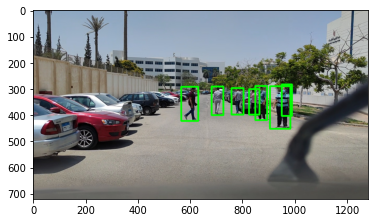

In [74]:
draw_bboxes(fid=15)

In [75]:
def get_transformed_points(M, points):
    # den = point @ M[2]  # M[2, 0] * x + M[2, 1] * y + M[2, 2]
    # x_new = point @ M[0] / den  # (M[0, 0] * x + M[0, 1] * y + M[0, 2]) / den
    # y_new = point @ M[1] / den  # (M[1, 0] * x + M[1, 1] * y + M[1, 2]) / den
    # return x_new, y_new
    assert points.shape[0] == 3, 'wrong points input shape: points.shape[0] must = 3' 
    new_points = M @ points
    new_points = new_points / new_points[2]
    # print(new_points)
    
    return new_points


def get_transformed_frame(M, fid):
    # den = point @ M[2]  # M[2, 0] * x + M[2, 1] * y + M[2, 2]
    # x_new = point @ M[0] / den  # (M[0, 0] * x + M[0, 1] * y + M[0, 2]) / den
    # y_new = point @ M[1] / den  # (M[1, 0] * x + M[1, 1] * y + M[1, 2]) / den
    # return x_new, y_new

    current = df.iloc[groups.get(fid)].set_index('uid')
    current['zpos'] = 1
    points = current[['xpos', 'ypos', 'zpos']].values.T
    # print(points)
    return get_transformed_points(M, points)
    

In [76]:
new_points = get_transformed_frame(M, fid=14)

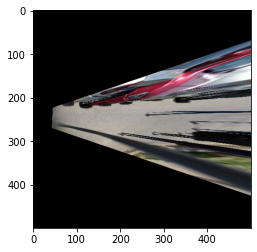

In [133]:
def ipm_from_opencv(image):
    # Warp the image
    warped = cv2.warpPerspective(image, M, (500, 500), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                                 borderValue=0)
    return warped

img = cv2.cvtColor(cv2.imread(f'frame{15}.jpg'), cv2.COLOR_BGR2RGB)
iimg = ipm_from_opencv(img)
plt.imshow(iimg)

In [80]:
new_points

array([[192.14358984, 337.01130176, 355.28571228, 341.89317589,
        270.2637793 , 255.6068504 , 357.9803691 ],
       [280.30843612, 307.28144825, 271.3958796 , 255.39408646,
        280.39711409, 237.68793847, 284.81562196],
       [  1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ]])

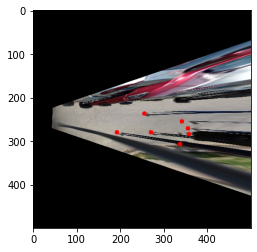

In [134]:

for i in range(new_points.shape[1]):
    iimg = cv2.circle(iimg, (int(new_points[0, i]), int(new_points[1, i])) , radius=0, color=(255, 0, 0), thickness=10)


plt.imshow(iimg)    

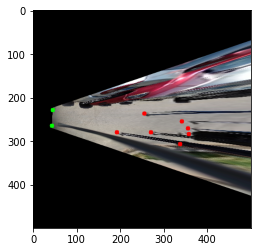

In [135]:
car_points = np.array([
    [186, 716, 1],
    [1137, 716, 1],
]).T
new_car_points = get_transformed_points(M, car_points)

for i in range(new_car_points.shape[1]):
    iimg = cv2.circle(iimg, (int(new_car_points[0, i]), int(new_car_points[1, i])) , radius=0, color=(0, 255, 0), thickness=10)

plt.imshow(iimg)

In [96]:
new_car_points

array([[ 45.10641664,  43.46589537],
       [229.90506099, 265.08091178],
       [  1.        ,   1.        ]])

In [26]:


def calc_velocity(fid, fps=30, n_frames=1):
    current = df.iloc[groups.get(fid)].set_index('uid')   
    # print(current_pos.values)
    try:
        prev = df.iloc[groups.get(fid-n_frames)].set_index('uid')
    except:
        prev = current.copy()
    
    uids = current.index

    displacements = {}
    for uid in uids:
        pos = current.loc[uid, ['xpos', 'ypos']].values
        prev_pos = np.zeros(shape=pos.shape)
        displacement = pos - prev_pos
        try:
            prev_pos = prev.loc[uid, ['xpos', 'ypos']].values
            displacement = pos - prev_pos
        except:
            pass

        displacements[uid] = displacement
    
    return displacements        
    

calc_velocity(10)

{1: array([4, 2]),
 2: array([-4, -1]),
 3: array([-3, -2]),
 4: array([-2, -4]),
 5: array([7, 0]),
 6: array([10,  0]),
 7: array([846., 407.])}

In [129]:
from numpy.linalg import norm

CAM_FPS = 30
N_FRAMES = 3
TIME_SEC = N_FRAMES / CAM_FPS 

SAFE_DISTANCE_THRESHOLD = 10
CAR_POINTS = np.array([
    [186, 716, 1],
    [1137, 716, 1],
]).T

TRANSFORMED_CAR_POINTS = get_transformed_points(M, CAR_POINTS)


def get_frame_data(fid):
    return df.iloc[groups.get(fid)].set_index('uid')


history = {}
for fid in [10]:
    fdata = get_frame_data(fid)
    fdata['xpos'] = fdata['x'] + fdata['w'] // 2
    fdata['ypos'] = fdata['y'] + fdata['h']
    fdata['zpos'] = 1
    
    foot_on_land_points = fdata[['xpos', 'ypos', 'zpos']].values.T
    new_points_matrix = get_transformed_points(M, foot_on_land_points)
    
    curr_points = {uid: new_points_matrix[:2, fdata.index.get_loc(uid)] for uid in fdata.index}
    # print(curr_points[1])
    # print(curr_points[1].shape)

    velocity = {
        uid: (curr_points[uid]-(history.get(uid) or curr_points[uid])) / TIME_SEC \
        for uid in curr_points
    }

    next_frame_points = {
        uid: curr_points[uid] + velocity[uid] * TIME_SEC 
        for uid in velocity
    }



    




    dists = np.array([
        norm(new_points_matrix - TRANSFORMED_CAR_POINTS[:, i].reshape(-1, 1), axis=0) for i in range(TRANSFORMED_CAR_POINTS.shape[1])
    ]).min(axis=0)
    
    # print((new_points_matrix - TRANSFORMED_CAR_POINTS[:, 0].reshape(-1, 1)).T)
    # print()
    # print(TRANSFORMED_CAR_POINTS)
    # print(norm(new_points_matrix - TRANSFORMED_CAR_POINTS[:, 0].reshape(-1, 1), axis=0))
    if np.min(dists) < SAFE_DISTANCE_THRESHOLD:
        print('fid =', fid, 'dists =', dists)
        print('STOP !!')
        break
    
# fdata = get_frame_data(10)
# fdata.head(10)
# print(df.index.get_loc(2))


[[154.27835425  50.6415742    0.        ]
 [277.87398095  75.81862817   0.        ]
 [304.88794541  41.15554988   0.        ]
 [291.87933623  25.38058944   0.        ]
 [221.94028724  50.13161433   0.        ]
 [210.42661854   7.1929164    0.        ]
 [269.33909943  50.83147859   0.        ]]

[162.37727558 288.0319664  307.65311398 292.98075233 227.53168978
 210.54951872 274.09376078]


In [132]:
# np.sqrt(304.88**2 + 41.16**2)
new_points[:2, 0].shape

(2,)

In [99]:
df.describe()

,fid,uid,x,y,w,h,xpos,ypos
count,8889.000000,8889.000000,8889.000000,8889.000000,8889.000000,8889.000000,8889.000000,8889.000000
mean,863.787378,11.818990,651.120598,245.427945,77.890764,196.323883,689.813365,441.751828
std,471.725879,6.935976,264.839654,26.136947,44.416672,103.682175,263.749849,89.615021
min,3.000000,1.000000,0.000000,135.000000,25.000000,78.000000,12.000000,321.000000
25%,494.000000,5.000000,459.000000,234.000000,49.000000,130.000000,490.000000,383.000000
50%,880.000000,11.000000,699.000000,246.000000,62.000000,152.000000,737.000000,407.000000
75%,1256.000000,16.000000,838.000000,258.000000,91.000000,226.000000,871.000000,475.000000
max,1649.000000,30.000000,1251.000000,322.000000,321.000000,584.000000,1265.000000,719.000000


In [29]:
import random
from collections import Counter
import matplotlib.pyplot as plt



In [1]:
x

NameError: name 'x' is not defined